# Introduction
This project begins with data ingestion and exploratory data analysis (EDA) to assess and understand wildfire risk data. Using geospatial wildfire data from 1878 to 2019 provided by the USGS, we processed and visualized patterns in wildfire occurrences, acres burned, and fire causes. The EDA highlighted temporal and regional trends, with visualizations like bar plots, pie charts, and heatmaps providing insights into seasonal and geographic patterns.

The first task focused on evaluating the 2018 predictions using 2019 wildfire data. By mapping predicted risks against observed wildfires, we analyzed the model's accuracy, generating confusion matrices and performance metrics (accuracy, precision, recall, and F1-score). Visualizations, such as risk maps and heatmaps, provided spatial insights into prediction quality.

The second task examined model drift, comparing the 2018 and 2022 risk scores to identify changes over time. Statistical tests confirmed significant shifts in predictions, with a transition matrix revealing how risk categories evolved. Clustering analysis highlighted regions with substantial risk changes, such as California and the Pacific Northwest, with notable increases in risk scores in some areas and decreases in others.

Overall, the project provides a comprehensive analysis of wildfire prediction performance, including accuracy evaluation, regional risk shifts, and insights into the model's adaptation to changing conditions.

**Wildfire Risk Prediction Analysis Catalog**

1. Data Ingestion
2. Exploratory Data Analysis (Wildfire Shapefile Data)
3. Task 1: Evaluate the 2018 Predictions
4. Task 2: Analyze Model Drift

## 1. Data Ingestion 

I downloads historical wildfire polygon data from the USGS ScienceBase repository. This data is critical for evaluating the alignment between 2018 wildfire predictions and actual wildfire occurrences in 2019. Data source: (https://www.sciencebase.gov/catalog/item/5ee13de982ce3bd58d7be7e7)

In [ ]:
import sciencebasepy
import requests
import os

# Initialize a ScienceBase session
sb = sciencebasepy.SbSession()

# ScienceBase item ID for the dataset
item_id = '5ee13de982ce3bd58d7be7e7'

# Retrieve item information
item = sb.get_item(item_id)

# Specify the file to download and the directory to save it
desired_filename = 'Wildfires_1878_2019_Polygon_Data.zip'
download_dir = 'sciencebase_downloads'
os.makedirs(download_dir, exist_ok=True)

# Find the specific file in the item
files = item.get('files', [])
file_to_download = next((file for file in files if file['name'] == desired_filename), None)

if file_to_download:
    # Get the file URL
    file_url = file_to_download['url']
    
    # Use requests to download the file
    response = requests.get(file_url, stream=True)
    if response.status_code == 200:
        file_path = os.path.join(download_dir, desired_filename)
        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"File '{desired_filename}' has been downloaded to '{file_path}'.")
    else:
        print(f"Failed to download the file. HTTP status code: {response.status_code}")
else:
    print(f"File '{desired_filename}' not found in the item.")

### 1.1 Extracting Wildfire Dataset

The script extracts the contents of the downloaded ZIP file (Wildfires_1878_2019_Polygon_Data.zip) into a designated directory (sciencebase_downloads/extracted_files), preparing the wildfire polygon data for further analysis and evaluation tasks.

In [ ]:
import zipfile

# Specify the path to the downloaded ZIP file
zip_file_path = 'sciencebase_downloads/Wildfires_1878_2019_Polygon_Data.zip'

# Specify the directory to extract the files to
extract_dir = 'sciencebase_downloads/extracted_files'
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f"Files have been extracted to '{extract_dir}'.")

### 1.2 Loading Wildfire Shapefile Data
I uses geopandas to load the extracted shapefile (US_Wildfires_1878_2019.shp) containing wildfire polygon data into a GeoDataFrame (gdf). This step ensures the spatial data is ready for exploration and analysis, with a preview of the dataset provided by displaying the first few rows.

In [1]:
import warnings
import geopandas as gpd

# Ignore all warnings
warnings.filterwarnings("ignore")

gdf = gpd.read_file("sciencebase_downloads/extracted_files/Wildfires_1878_2019_Polygon_Data/Shapefile/US_Wildfires_1878_2019.shp")

gdf.head()

,FireName,FireCode,FireYear,IgntDate,ContrlDate,ContnDate,Acres,Hectares,DataSrc,DataNotes,FireCause,FoundIn,FndNames,FndCodes,FndDates,FireQual,Shape_Leng,Shape_Area,geometry
0,414008,AK6535415457219840611,1984,1984/06/11,0000/00/00,0000/00/00,3169.156439,1282.513243,Monitoring Trends in Burn Severity,"First Tier Wildfires, polygon with largest acr...",No cause indicated,Alternate Fire Sources: Monitoring Trends in B...,Alternate Fire Names: 414008,Alternate Fire Codes: AK6535415457219840611,"Alternate Ignition, Controlled, and Contained ...",1,22876.846278,1.282513e+07,"POLYGON ((-2729116.221 3783619.593, -2728840.2..."
1,414012,AK6621715235619840618,1984,1984/06/18,0000/00/00,0000/00/00,1964.386646,794.959774,Monitoring Trends in Burn Severity,"First Tier Wildfires, polygon with largest acr...",No cause indicated,Alternate Fire Sources: Monitoring Trends in B...,Alternate Fire Names: 414012,Alternate Fire Codes: AK6621715235619840618,"Alternate Ignition, Controlled, and Contained ...",1,17290.576444,7.949598e+06,"POLYGON ((-2587275.964 3793164.935, -2586775.6..."
2,414057,AK6495716269319840702,1984,1984/07/02,0000/00/00,0000/00/00,1688.849283,683.453661,Monitoring Trends in Burn Severity,"First Tier Wildfires, polygon with largest acr...",No cause indicated,Alternate Fire Sources: Monitoring Trends in B...,Alternate Fire Names: 414057,Alternate Fire Codes: AK6495716269319840702,"Alternate Ignition, Controlled, and Contained ...",1,11226.497241,6.834537e+06,"POLYGON ((-3073104.885 3996965.523, -3073150.7..."
3,414060,AK6379515502919840623,1984,1984/06/23,0000/00/00,0000/00/00,1399.226822,566.247506,Monitoring Trends in Burn Severity,"First Tier Wildfires, polygon with largest acr...",No cause indicated,Alternate Fire Sources: Monitoring Trends in B...,Alternate Fire Names: 414060,Alternate Fire Codes: AK6379515502919840623,"Alternate Ignition, Controlled, and Contained ...",1,18047.888216,5.662475e+06,"POLYGON ((-2841528.411 3660892.172, -2841473.4..."
4,ABERT,OR4258812018119840809,1984,1984/08/09,0000/00/00,0000/00/00,7945.460289,3215.416542,Monitoring Trends in Burn Severity,"First Tier Wildfires, polygon with largest acr...",No cause indicated,Alternate Fire Sources: BLM National Fire Peri...,"Alternate Fire Names: Abert, Abert, ABERT","Alternate Fire Codes: M053, M053, OR4258812018...","Alternate Ignition, Controlled, and Contained ...",1,73017.681929,3.215417e+07,"POLYGON ((-1839066.54 551133.989, -1839104.379..."


## 2. Exploratory Data Analysis (Wildfire Shapefile Data)
I used geopandas to load the shapefile (US_Wildfires_1878_2019.shp) into a GeoDataFrame (gdf). To understand the structure of the dataset, I examine the column data types and identify any missing values, ensuring the data is ready for analysis.

The wildfire dataset containing 65,845 entries and 19 columns, including details like FireName, FireYear, Acres, Hectares, and FireCause. The data spans from 1878 to 2019, with an average wildfire size of 3,268 acres and significant variability, as the largest wildfire exceeded 1.3 million acres. The most frequent fire causes were "No cause indicated" (26,375 cases) and "Unknown/Unidentified" (7,723 cases), followed by natural causes like lightning and human-related factors. This overview provides valuable insights into wildfire characteristics and causes, laying the groundwork for deeper analysis.

In [2]:
gdf.info()  # Get column data types and missing values

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 65845 entries, 0 to 65844
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FireName    65845 non-null  object  
 1   FireCode    65845 non-null  object  
 2   FireYear    65845 non-null  int32   
 3   IgntDate    65845 non-null  object  
 4   ContrlDate  65845 non-null  object  
 5   ContnDate   65845 non-null  object  
 6   Acres       65845 non-null  float64 
 7   Hectares    65845 non-null  float64 
 8   DataSrc     65845 non-null  object  
 9   DataNotes   65845 non-null  object  
 10  FireCause   65845 non-null  object  
 11  FoundIn     65845 non-null  object  
 12  FndNames    65845 non-null  object  
 13  FndCodes    65845 non-null  object  
 14  FndDates    65845 non-null  object  
 15  FireQual    65845 non-null  int32   
 16  Shape_Leng  65845 non-null  float64 
 17  Shape_Area  65845 non-null  float64 
 18  geometry    65845 non-null  geometry
d

In [3]:
gdf.describe()  # Get statistical summary of numerical data

,FireYear,Acres,Hectares,FireQual,Shape_Leng,Shape_Area
count,65845.000000,6.584500e+04,65845.000000,65845.000000,6.584500e+04,6.584500e+04
mean,1987.814701,3.267803e+03,1322.434285,1.758144,1.562231e+04,1.322434e+07
std,30.445695,1.947511e+04,7881.302426,0.442307,8.275278e+04,7.881302e+07
min,1878.000000,7.729207e-06,0.000003,1.000000,6.295801e-01,3.127902e-02
25%,1975.000000,3.190867e+01,12.912994,2.000000,1.799712e+03,1.291299e+05
50%,1999.000000,2.472287e+02,100.050012,2.000000,5.267941e+03,1.000500e+06
75%,2011.000000,1.434660e+03,580.586814,2.000000,1.497574e+04,5.805868e+06
max,2019.000000,1.374246e+06,556137.985899,3.000000,1.341586e+07,5.561380e+09


In [4]:
gdf['FireCause'].value_counts().head(10)  # Count top 10 fire causes

No cause indicated             26375
14 - Unknown / Unidentified     7723
Natural                         6366
Unknown                         5960
Human                           5016
1 - Lightning                   4950
9 - Miscellaneous               4309
2 - Equipment Use                905
4 - Campfire                     833
7 - Arson                        688
Name: FireCause, dtype: int64

### 2.1 Data Processing

#### 2.1.1 Coordinate System Conversion

The dataset is converted to the WGS84 coordinate reference system (EPSG:4326), which uses latitude and longitude. This step ensures compatibility with spatial analyses and mapping tools, making the data easier to interpret in global contexts.

In [5]:
gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 for longitude/latitude

#### 2.1.2 Fire Cause Aggregation
A custom function groups detailed fire causes into broader categories (Unknown, Natural, Human, and Other) for simplification and analysis. 

In [6]:
# Define aggregation rules
def aggregate_firecause(cause):
    cause = cause.lower()  # Make case insensitive
    if 'unknown' in cause or 'no cause' in cause or 'undetermined' in cause:
        return 'Unknown'
    elif 'natural' in cause or 'lightning' in cause:
        return 'Natural'
    elif 'human' in cause or 'arson' in cause or 'campfire' in cause or 'smoking' in cause or 'debris' in cause or 'vehicle' in cause:
        return 'Human'
    else:
        return 'Other'

# Apply aggregation
gdf['Category'] = gdf['FireCause'].apply(aggregate_firecause)

#### 2.1.3. Yearly Acres Burned and Fire Occurrences:
The dataset is grouped by FireYear to calculate total acres burned (acres_sum) and the number of wildfire occurrences per year. This aggregation highlights yearly trends and provides insights into the scale and frequency of wildfires, crucial for evaluating predictions and understanding historical patterns.

In [7]:
# acres burned - aggregate by year
acres_sum = gdf.groupby(by = 'FireYear').Acres.sum()

occurrences_per_year = gdf['FireYear'].value_counts().sort_index()

#### 2.1.4. Processing for Quarterly Analysis:
A function (process_and_plot_quarter_pie_chart) processes data to group fire dates by calendar quarters (Q1, Q2, Q3, Q4) and assigns Blank for invalid or missing dates. This step is critical for analyzing seasonal patterns in wildfire occurrences, which can inform mitigation strategies.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def process_and_plot_quarter_pie_chart(data, date_column, title, figsize=(5, 5)):
    """
    Processes the dataset to group dates by quarter (including invalid dates as 'Blank') 
    and plots a pie chart.
    
    Parameters:
    - data: Pandas DataFrame containing the date column.
    - date_column: Name of the column containing dates as strings.
    - title: Title for the pie chart.
    - figsize: Tuple specifying the figure size of the chart.
    """
    # Separate invalid dates
    data['ValidDate'] = pd.to_datetime(data[date_column], errors='coerce')
    
    # Assign 'Blank' for invalid dates
    data['Quarter'] = data['ValidDate'].dt.quarter.fillna('Blank')
    
    # Group by quarter and count occurrences
    quarter_counts = data['Quarter'].value_counts()
    
    # Define the desired quarter order and labels
    quarter_order = [1, 2, 3, 4, 'Blank']
    labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Blank']
    
    # Reindex the quarter_counts to match the desired order
    quarter_counts = quarter_counts.reindex(quarter_order)
    
    # Plotting the pie chart
    plt.figure(figsize=figsize)
    wedges, texts, autotexts = plt.pie(
        quarter_counts, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        textprops={'fontsize': 12}, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    
    # Add a title
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Adding a legend sorted by quarters
    plt.legend(wedges, labels, title="Quarters", loc="upper right", bbox_to_anchor=(1.15, 1))
    
    # Display the plot
    plt.tight_layout()
    plt.show()

### 2.2 Visualization Insights (1878 - 2019)

We created various plots to analyze wildfire patterns, including a pie chart for wildfire occurrences by quarter, bar plots for fire cause distribution, line charts for annual acres burned and wildfire occurrences, and a violin plot for the Log10 of Acres Burned by year. From these visualizations, we found that wildfires peak in Q3, reflecting seasonal trends, and many fire causes are categorized as unknown, though natural and human-related causes are significant contributors. We observed a marked increase in wildfire occurrences and intensity over time, particularly after 1980, with larger and more destructive fires becoming more frequent. The Log10 of Acres Burned plot highlighted the prevalence of smaller fires but revealed extreme outliers in years like 2017 and 2018, where large-scale fires had a significant impact. These findings emphasize the growing challenges in wildfire prediction and management.

#### 2.2.1. Wildfire Occurrences by Quarter:
48.2% of wildfire records have no valid ignition date (labeled as "Blank"). Among valid records, most wildfires occurred in Q3 (28.7%), followed by Q2 (14.8%), indicating a seasonal peak during the summer months, likely due to higher temperatures and dry conditions.

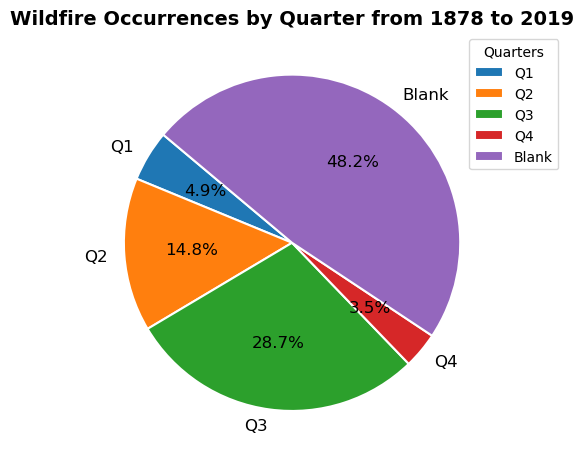

In [9]:
# Call the function
process_and_plot_quarter_pie_chart(
    data=gdf,
    date_column='IgntDate',
    title='Wildfire Occurrences by Quarter from 1878 to 2019',
    figsize=(5, 5)
)

#### 2.2.2. Fire Cause Distribution:
The majority of wildfires fall under the "Unknown" category (40,213 occurrences). Natural causes (e.g., lightning) account for a significant portion (11,468 occurrences), followed by human-related causes (8,155 occurrences), emphasizing the need for targeted prevention strategies.

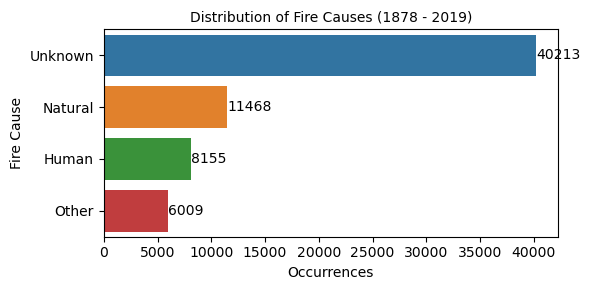

In [10]:
import seaborn as sns
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=gdf, y='Category', order=gdf['Category'].value_counts().index)

# Add the count labels to each bar
for bar in ax.patches:
    # Get the dimensions of each bar
    width = bar.get_width()  # Width corresponds to the count
    y = bar.get_y() + bar.get_height() / 2  # Center the text vertically
    ax.text(width + 0.5, y, int(width), va='center')  # Add a small offset and display count


plt.title('Distribution of Fire Causes (1878 - 2019)', fontsize=10)
plt.xlabel('Occurrences', fontsize=10)
plt.ylabel('Fire Cause', fontsize=10)
plt.tight_layout()
plt.show()

#### 2.2.3. Annual Total Acres Burned (1878–2019):
There is a noticeable increase in wildfire intensity over time, with significant spikes in total acres burned after the 1980s, reflecting changing environmental conditions and fire management challenges.

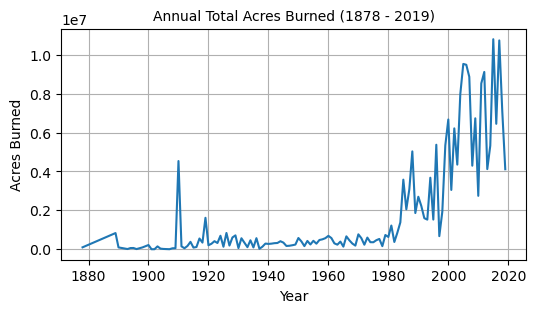

In [11]:
plt.figure(figsize=(6, 3))
plt.plot(acres_sum.index, acres_sum)
plt.grid()
plt.xlabel('Year', fontsize=10)
plt.ylabel('Acres Burned', fontsize=10)
plt.title('Annual Total Acres Burned (1878 - 2019)', fontsize=10)
plt.show()

#### 2.2.4. Annual Total Acres Burned by Cause (1980–2019):
Fires attributed to unknown causes dominate acreage burned, but fires caused by natural and human-related activities also show consistent trends, necessitating cause-specific mitigation efforts.

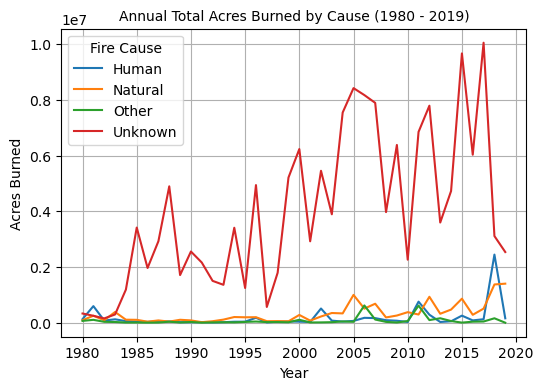

In [12]:
gdf_after1980 = gdf[gdf['FireYear'] >= 1980]
# Group by year and cause, then count occurrences
acres_sum_cause = gdf_after1980.groupby(['FireYear', 'Category']).Acres.sum().unstack(fill_value=0)
# Plot the data
plt.figure(figsize=(6, 4))
for cause in acres_sum_cause.columns:
    plt.plot(acres_sum_cause.index, acres_sum_cause[cause], label=cause)
plt.title('Annual Total Acres Burned by Cause (1980 - 2019)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Acres Burned', fontsize=10)
plt.legend(title='Fire Cause', fontsize=10)
plt.grid(True)
plt.show()

#### 2.2.5. Log10 of Acres Burned by Year (2010–2019):
The violin plot of the Log10 of Acres Burned (2010–2019) highlights significant variability in wildfire sizes across years. The distribution is heavily skewed, with the majority of fires being relatively small, as indicated by the dense lower portion of the plot. However, the presence of long tails and outliers reflects the occurrence of extremely large fires, which have a disproportionate impact on the total area burned. Notably, certain years, such as 2017 and 2018, exhibit a broader spread and more prominent outliers, suggesting a higher frequency of large-scale wildfire events during those years. These findings underscore the increasing intensity and unpredictability of wildfires, emphasizing the need for improved forecasting models and targeted mitigation strategies for extreme fire events.

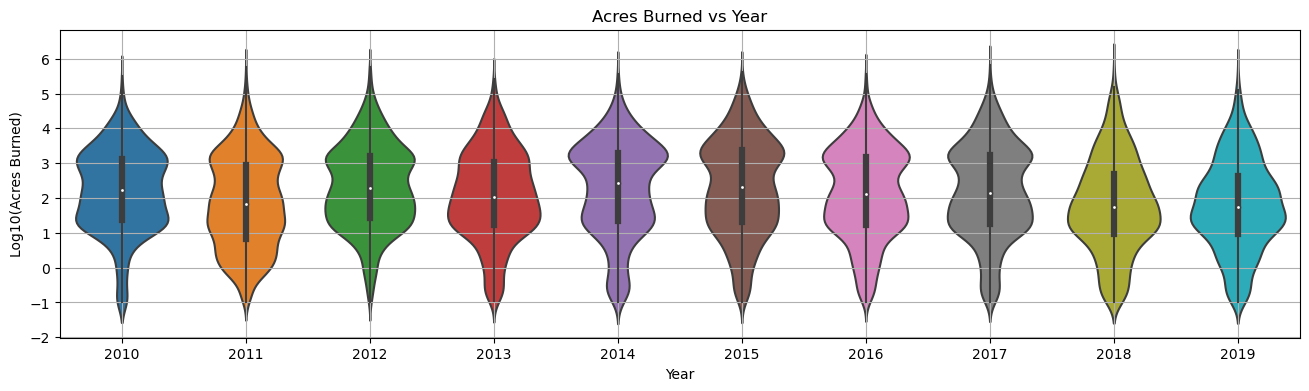

In [13]:
import numpy as np
tenyeargdf = gdf[gdf['FireYear'] >= 2010]
tenyeargdf['log10AcresBurned'] = np.log10(tenyeargdf.Acres+0.1) # add 0.1 to avoid problems with l

plt.figure(figsize=(16,4))
sns.violinplot(x='FireYear', y='log10AcresBurned', data=tenyeargdf)
plt.xlabel('Year')  # Add x-axis label
plt.ylabel('Log10(Acres Burned)')  # Add y-axis label
plt.grid()
plt.title('Acres Burned vs Year')
plt.show()

#### 2.2.6. Wildfire Occurrences Per Year (1878 - 2019):
The frequency of wildfires has increased significantly over time, with the highest occurrence rates observed post-2000, indicating a growing challenge in wildfire management.

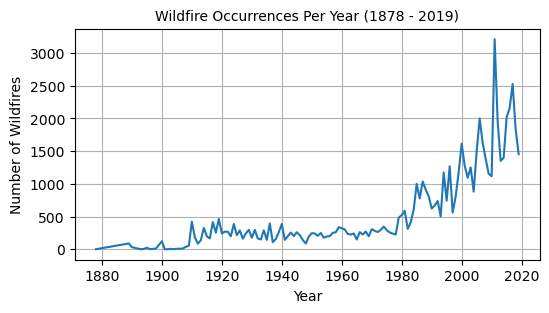

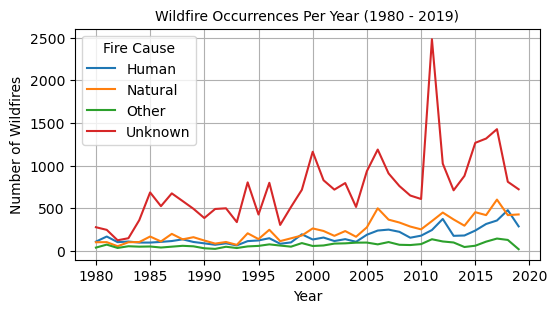

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(occurrences_per_year.index, occurrences_per_year.values, linestyle='-')
plt.title('Wildfire Occurrences Per Year (1878 - 2019)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Wildfires', fontsize=10)
plt.grid(True)
plt.show()

# Group by year and cause, then count occurrences
cause_per_year = gdf_after1980.groupby(['FireYear', 'Category']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(6, 3))
for cause in cause_per_year.columns:
    plt.plot(cause_per_year.index, cause_per_year[cause], label=cause)


#plt.plot(occurrences_per_year.index, occurrences_per_year.values, linestyle='-')
plt.title('Wildfire Occurrences Per Year (1980 - 2019)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Wildfires', fontsize=10)
plt.legend(title='Fire Cause', fontsize=10)
plt.grid(True)
plt.show()

### 2.3 Wildfire Analysis for 2019

To analyze wildfires in 2019, I filtered the dataset to include only wildfires that occurred that year. I created a bar chart to visualize the distribution of fire causes, revealing the prevalence of unknown, natural, and human-related causes. A pie chart was also generated to examine the seasonal distribution of wildfires, highlighting a peak in Q3. Additionally, I created two interactive maps using folium. The first map visualized wildfire locations with polygons and circle markers, categorized by fire causes and scaled by acres burned. The second map was a heatmap displaying wildfire intensity across the U.S., with areas weighted by the size of burned acres. By combining these visualizations, we gained a detailed understanding of wildfire causes, seasonal trends, and geographic intensity for 2019, providing valuable insights for evaluating model predictions.

In [15]:
gdf_2019 = gdf[gdf['FireYear'] == 2019]

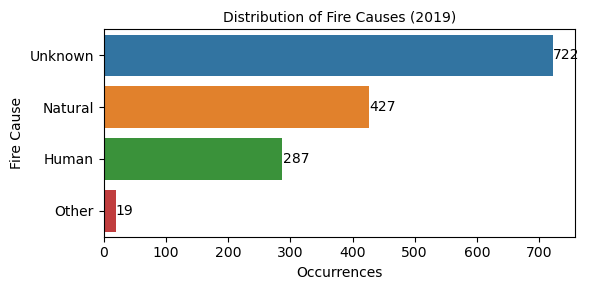

In [16]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=gdf_2019, y='Category', order=gdf_2019['Category'].value_counts().index)

# Add the count labels to each bar
for bar in ax.patches:
    # Get the dimensions of each bar
    width = bar.get_width()  # Width corresponds to the count
    y = bar.get_y() + bar.get_height() / 2  # Center the text vertically
    ax.text(width + 0.5, y, int(width), va='center')  # Add a small offset and display count

plt.title('Distribution of Fire Causes (2019)', fontsize=10)
plt.xlabel('Occurrences', fontsize=10)
plt.ylabel('Fire Cause', fontsize=10)
plt.tight_layout()
plt.show()

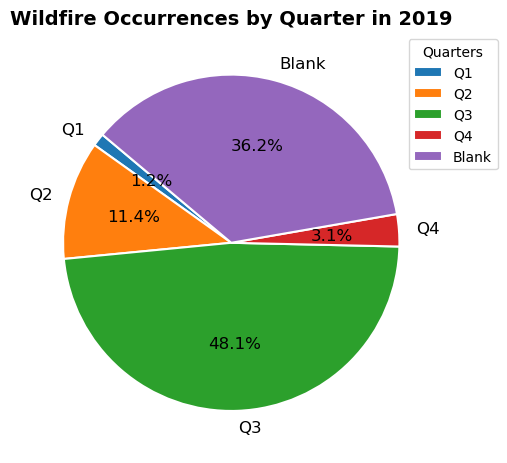

In [17]:
process_and_plot_quarter_pie_chart(
    data=gdf_2019,
    date_column='IgntDate',
    title='Wildfire Occurrences by Quarter in 2019',
    figsize=(5, 5))

In [18]:
import folium
# Create a base map using folium
m = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Define color mapping for fire causes
color_mapping = {
    'Unknown': '#FF0000',  # Red
    'Natural': '#FFA500',  # Orange
    'Human': '#0000FF',    # Blue
}
default_color = '#800080'  # Purple for other causes


# Add polygons to the map
for _, row in gdf_2019.iterrows():
    # Extract geometry and additional info (e.g., fire cause)
    poly = row['geometry']
    fire_cause = row.get('Category', 'Unknown')  
    acres_burned = row.get('Acres', 0)  
    color = color_mapping.get(fire_cause, default_color)  # Default to gray for any unmatched causes

    # Add polygon to the map
    folium.GeoJson(
        poly,
        style_function=lambda x, col=color: {
            'fillColor': col,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9
        },
        tooltip=f"Cause: {fire_cause}<br>Acres Burned: {acres_burned}"
    ).add_to(m)
    
    # Add a circle marker for the fire's centroid
    if poly.geom_type == 'Polygon' or poly.geom_type == 'MultiPolygon':
        centroid = poly.centroid
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=5,  # Circle marker size
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            fill_opacity=0.7,
            tooltip=f"Cause: {fire_cause}<br>Acres Burned: {acres_burned}"
        ).add_to(m)

#Add a legend for fire causes
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: auto; 
background-color: white; z-index:9999; font-size:14px; border:1px solid black; padding: 10px;">
<strong>Fire Causes</strong><br>
<i style="background: #FF0000; width: 20px; height: 10px; display: inline-block;"></i> Unknown<br>
<i style="background: #FFA500; width: 20px; height: 10px; display: inline-block;"></i> Natural<br>
<i style="background: #0000FF; width: 20px; height: 10px; display: inline-block;"></i> Human<br>
<i style="background: #800080; width: 20px; height: 10px; display: inline-block;"></i> Other<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
m.save("map2019_point.html")

In [19]:
from folium.plugins import HeatMap
# Ensure the GeoDataFrame has centroids calculated
gdf_2019['centroid'] = gdf_2019.geometry.centroid

# Create a base map using folium
m2 = folium.Map(location=[37.0902, -103.7129], zoom_start=4)
# Prepare data for the heat map
# Using centroid coordinates for heat map locations, weighted by AcresBurned
heat_data = [
    [row.centroid.y, row.centroid.x]
    for _, row in gdf_2019.iterrows()
    if not row.geometry.is_empty
]

# Add the heat map layer
HeatMap(heat_data, radius=10, blur=10, max_zoom=13, gradient=None).add_to(m2)
m2.save("heat_map2019.html")

In [20]:
from IPython.display import HTML

# Create HTML for displaying two maps side by side
html = """
<div style="display: flex; flex-direction: row; justify-content: space-around; align-items: flex-start;">
    <div style="text-align: center; width: 50%;">
        <h3>Map 1: Fire Causes and Burned Areas (2019)</h3>
        <iframe src="map2019_point.html" width="100%" height="500"></iframe>
    </div>
    <div style="text-align: center; width: 50%;">
        <h3>Map 2: Heatmap 2019</h3>
        <iframe src="heat_map2019.html" width="100%" height="500"></iframe>
    </div>
</div>
"""

# Render the HTML in Jupyter Notebook
HTML(html)


### 2.3.1 Summary 

The two maps provide complementary insights into wildfires across the U.S. in 2019. Map 1 visualizes wildfire locations, categorized by fire causes—Unknown (red), Natural (orange), Human (blue), and Other (purple)—with the size representing the area burned. This map highlights the concentration of wildfires in the western United States, where natural causes dominate in areas prone to dry conditions and lightning strikes. Map 2 is a heatmap showing the intensity of wildfire occurrences, revealing hotspots in regions like California, Arizona, and the Great Plains. The heatmap emphasizes the geographic spread and density of wildfires, aiding in identifying high-risk areas for future prevention and mitigation strategies. Together, these visualizations offer a detailed understanding of wildfire patterns, causes, and impacts in 2019.

## 3. Task 1: Evaluate the 2018 Predictions

To evaluate the 2018 wildfire predictions, I first loaded the prediction dataset, which included risk scores for each location. I categorized the risk scores into levels (Low, Medium, High, and Extreme High) and visualized their spatial distribution using a Folium map. Additionally, I created a heatmap to represent the intensity of predicted wildfire risks geographically, highlighting areas with higher risk scores.

I set a threshold for the prediction data, treating any risk score classified as "High" or "Extreme High" as 1 (predicting that a fire would occur) and all others as 0 (no fire). This allowed me to create binary predictions and generate a confusion matrix for comparison with actual wildfire occurrences in 2019.

Using spatial joins, I compared the predicted locations with actual wildfire polygons for 2019, counting how many predicted points overlapped with wildfire areas. I calculated metrics such as accuracy, precision, recall, and F1-score to evaluate the model's performance and generated a confusion matrix to summarize the results. The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) further assessed the model's ability to distinguish fire from no-fire zones.

By setting this threshold and conducting a detailed evaluation, I was able to measure how well the 2018 predictions aligned with actual wildfire occurrences in 2019 and identify areas for improving the model's accuracy and predictive reliability.

### 3.1 Load model prediction dataset

In [21]:
sheet_name = 'wildfire_risk_data_set' # load model prediction dataset
sheet_id = '1QjMq-88mU2ZTw8TnFQdV7-mR1xJISxQX' 
url =  f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

In [22]:
sample_data = pd.read_csv(url)
sample_data.head()
sample_data = sample_data.dropna(subset=['latitude', 'longitude', 'score_2018'])

### 3.2 Check risk distribution

In [23]:
sample_data['score_2018'].value_counts()

1.0     3430
2.0      706
3.0      461
7.0      313
4.0      309
5.0      253
6.0      252
8.0      244
9.0       20
10.0       6
0.0        2
Name: score_2018, dtype: int64

### 3.3 Categorized the risk scores and set a threshold for the prediction

In [24]:
sample_data['prediction'] = sample_data['score_2018'].apply(lambda x: 0 if x < 5 else 1)
sample_data['predicted_prob'] = sample_data['score_2018']/10

def risk_bucket(score):
    if score <= 2:
        return 'Low risk'
    elif score <= 4:
        return 'Medium risk'
    elif score <= 6:
        return 'High risk'
    else:
        return 'Extreme High risk'

sample_data['risk_bucket_2018'] = sample_data['score_2018'].apply(risk_bucket)
sample_data['risk_bucket_2022'] = sample_data['score_2022'].apply(risk_bucket)

### 3.4 Visualized spatial distribution

In [25]:
# Define a color mapping for risk_bucket_2018 categories
color_mapping = {
    'Low risk': 'lightgreen',  # Green
    'Medium risk': '#FFFF00',  # Yellow
    'High risk': '#FFA500',  # Orange
    'Extreme High risk': '#FF0000',  # Red
}

# Create a Folium Map centered around the mean latitude and longitude
mymap = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Add markers with colors based on 'risk_bucket_2018'
for _, row in sample_data.iterrows():
    risk_category = row['risk_bucket_2018']  # Ensure this column exists in your dataset
    color = color_mapping.get(risk_category, '#808080')  # Default to gray if category is missing

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,  # Size of the dot
        color=color,  # Dot outline color
        fill=True,
        fill_color=color,  # Fill color
        fill_opacity=0.1,  # Transparency
        tooltip=f"Risk: {risk_category}"  # Show risk category on hover
    ).add_to(mymap)

# Add a legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
            padding: 10px; border-radius: 5px;">
    <strong>Risk Categories</strong><br>
    <i style="background: #00FF00; width: 10px; height: 10px; display: inline-block;"></i> Low risk<br>
    <i style="background: #FFFF00; width: 10px; height: 10px; display: inline-block;"></i> Medium risk<br>
    <i style="background: #FFA500; width: 10px; height: 10px; display: inline-block;"></i> High risk<br>
    <i style="background: #FF0000; width: 10px; height: 10px; display: inline-block;"></i> Extreme High risk<br>
</div>
'''

# Add the legend to the map
mymap.get_root().html.add_child(folium.Element(legend_html))

# Display the map
mymap.save("predict_map2018.html")

In [26]:
from IPython.core.display import HTML
# Initialize the map centered around the US (adjust the location and zoom as needed)
m_risk = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Create a list of data points for the heat map
heat_data = [
    [row['latitude'], row['longitude'], row['score_2018']] 
    for index, row in sample_data.iterrows()
]

# Add the heat map to the folium map
HeatMap(heat_data, min_opacity=0.5, radius=10, blur=10, max_zoom=13).add_to(m_risk)

m_risk.save("heat_map2018.html")

In [27]:
from IPython.display import HTML

# Create HTML for displaying two maps side by side
html = """
<div style="display: flex; flex-direction: row; justify-content: space-around; align-items: flex-start;">
    <div style="text-align: center; width: 50%;">
        <h3>Map 1: WildFire Prediction by risk level (2018)</h3>
        <iframe src="predict_map2018.html" width="100%" height="500"></iframe>
    </div>
    <div style="text-align: center; width: 50%;">
        <h3>Map 2: Heatmap 2018</h3>
        <iframe src="heat_map2018.html" width="100%" height="500"></iframe>
    </div>
</div>
"""

# Render the HTML in Jupyter Notebook
HTML(html)

### 3.5 Spatial Matching and Model Evaluation

I created a GeoDataFrame (locations_gdf) from the prediction data, using latitude and longitude to generate point geometries. The coordinate reference system (CRS) was matched with the actual wildfire data for 2019. I then iterated through the wildfire polygons for 2019 and checked if each predicted point fell within a polygon. The results were aggregated in the Occurrences column, which counts how many predictions aligned with actual wildfire areas.

Using the binary predictions (prediction) and the calculated Occurrences, I generated a confusion matrix to compare the predicted fire locations with actual occurrences. Key performance metrics, including accuracy, precision, recall, and F1-score, were calculated to assess the model's effectiveness. 

In [28]:
from shapely.geometry import Point, Polygon

# Step 1: Create GeoDataFrame for locations
locations_gdf = gpd.GeoDataFrame(
    sample_data,
    geometry=gpd.points_from_xy(sample_data['longitude'], sample_data['latitude']),
    crs=gdf_2019.crs  # Match the CRS
)

# Initialize a column to count occurrences
locations_gdf["Occurrences"] = 0

# Loop through polygons and check each point
for i, polygon in enumerate(gdf_2019.geometry):
    # Check if points are within the current polygon
    within_polygon = locations_gdf.geometry.within(polygon)
    # Add the count of matches to the 'Occurrences' column
    locations_gdf["Occurrences"] += within_polygon.astype(int)

# Step 4: Save or display results
locations_gdf = locations_gdf[['latitude', 'longitude', 'predicted_prob','prediction','Occurrences']]

locations_gdf.head()

,latitude,longitude,predicted_prob,prediction,Occurrences
0,35.044362,-86.563091,0.1,0,0
1,38.237693,-85.808600,0.1,0,0
2,38.109057,-85.697202,0.1,0,0
3,38.292902,-85.617247,0.1,0,0
4,32.433956,-97.104333,0.1,0,0


In [29]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Generate confusion matrix
conf_matrix = confusion_matrix(locations_gdf['Occurrences'], locations_gdf['prediction'])

# Calculate metrics
accuracy = accuracy_score(locations_gdf['Occurrences'], locations_gdf['prediction'])
precision = precision_score(locations_gdf['Occurrences'], locations_gdf['prediction'])
recall = recall_score(locations_gdf['Occurrences'], locations_gdf['prediction'])
f1 = f1_score(locations_gdf['Occurrences'], locations_gdf['prediction'])

# Display metrics
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(locations_gdf['Occurrences'], locations_gdf['prediction'], target_names=["No Fire", "Fire"]))


Model Performance:
Accuracy: 0.92
Precision: 0.74
Recall: 0.81
F1-Score: 0.77

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.96      0.94      0.95      4998
        Fire       0.74      0.81      0.77       998

    accuracy                           0.92      5996
   macro avg       0.85      0.88      0.86      5996
weighted avg       0.92      0.92      0.92      5996



In [30]:
# Optional: Display as a labeled table
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Fire', 'Fire'])

from sklearn.metrics import roc_curve, auc, RocCurveDisplay
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(locations_gdf['Occurrences'], locations_gdf['predicted_prob'])

# Calculate AUC
roc_auc = auc(fpr, tpr)

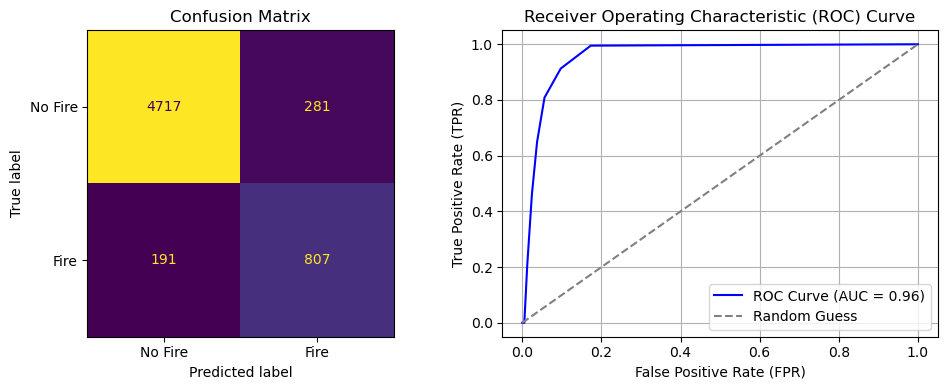

In [31]:
# Create a horizontal subplot layout
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot Confusion Matrix
plt.sca(axes[0])
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix")

# Plot ROC Curve
axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
axes[1].set_xlabel("False Positive Rate (FPR)")
axes[1].set_ylabel("True Positive Rate (TPR)")
axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
axes[1].legend(loc="lower right")
axes[1].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()

## 3.6 Task 1 Conclusion
The evaluation of the 2018 wildfire predictions showed that the model performed well overall, with an accuracy of 92%, meaning it made correct predictions (fire or no fire) for the majority of the locations. The precision of 74% means that out of all the locations where the model predicted a fire, 74% of them were actual fires, while the rest (26%) were false alarms. The recall of 81% indicates that the model was able to identify 81% of the actual fires, but it missed about 19% of them. The F1-Score, which combines precision and recall, was 77%, showing a good balance between these two aspects.

When predicting areas with no fire, the model was highly accurate, correctly identifying them 96% of the time. For areas where fires occurred, the model correctly predicted 81% of these cases, though it made some mistakes by either missing fires or predicting fires where there were none. The ROC curve, which measures how well the model can distinguish between fire and no-fire areas, had an AUC of 0.96, which is excellent. This means the model is very effective at identifying fire-prone areas, but there is room for improvement in reducing the number of false alarms and missed fires.

**Potential Improvements Based on Current Settings**

1. Adjusting the Threshold for Predictions:
The current threshold classifies scores of "High" or above as a fire prediction. Adjusting this threshold (e.g., lowering it slightly) could improve the model's recall, ensuring more actual fires are identified. However, this may increase false positives, so finding an optimal threshold through sensitivity analysis or ROC curve evaluation would balance precision and recall.
2. Using Weighted Risk Scores:
Instead of a binary threshold, a weighted scoring system could be introduced to prioritize areas with higher probabilities of fires. This would help in focusing resources on areas with extreme risk while reducing unnecessary attention to borderline predictions.
3. Enhancing the Matching Algorithm:
The current spatial matching approach checks whether predicted points fall strictly within fire polygons. This could be improved by implementing a proximity-based matching algorithm (e.g., buffer zones around polygons) to capture near-misses, especially for areas where the prediction point is just outside a fire polygon.

## 4. Task 2: Analyze Model Drift 

To analyze model drift between 2018 and 2022, I compared the wildfire risk scores to assess how predictions have changed over time.

1. **Data Cleaning**:
Outliers (risk scores above 10) and missing data were removed to ensure a clean dataset.
A new column (risk_diff) was created to calculate the difference between 2022 and 2018 risk scores, highlighting areas with changes in predicted risk.
2. **Visualizing Risk Score Changes**:
I plotted the distributions of 2018 and 2022 risk scores using kernel density plots, which showed notable shifts in the risk profile over time.
Locations with significant risk changes (e.g., risk_diff ≤ -3 or ≥ 5) were identified and visualized.
3. **Geospatial Analysis**:
Heatmaps were created to visualize the geographic distribution of 2022 risk scores and areas with significant changes in risk (using risk_diff).
Two maps (2018 and 2022) were displayed side by side to compare the spatial patterns of risk predictions.
4. **Statistical Tests**:
A paired t-test was conducted to evaluate whether the difference in risk scores was statistically significant, confirming notable drift in predictions.
A risk bucket transition matrix was created to track movement between risk categories (e.g., Low to High) over time, using a heatmap for better interpretation.
5. **Population Stability Index (PSI)**:
PSI was calculated to quantify the magnitude of drift between the 2018 and 2022 score distributions. A high PSI value would indicate significant changes in the prediction model's behavior.
6. **Clustering and Regional Trends**:
K-Means clustering was applied to group locations with similar changes in risk (risk_diff), helping to identify geographic regions with systematic prediction shifts.
Cluster-level summaries were calculated, including the mean risk difference for each cluster, and results were visualized on an interactive map with cluster centroids and detailed tooltips.

### 4.1 Data Cleaning

In [32]:
# Remove outliers & NA 
sample_data = sample_data[sample_data['score_2022']<=10] 
sample_data = sample_data.dropna(subset=['score_2022'])
# Calculate Risk Difference
sample_data['risk_diff'] = sample_data['score_2022'] - sample_data['score_2018']

### 4.2 Descriptive statistics show overall changes in risk scores

The analysis of 2018 and 2022 risk scores revealed that the average risk slightly increased from 2.44 in 2018 to 2.51 in 2022, with a mean difference (risk_diff) of 0.07, indicating minimal overall change. The majority of locations (93%) showed no change in risk scores (risk_diff = 0), while small portions experienced positive or negative shifts, such as 121 locations with a +2 increase and 119 with a -1 decrease. The risk scores' distributions, visualized via density plots, highlight similar patterns between the two years, with slightly more variability in 2022. The risk_diff ranged from -6 to +6, emphasizing that while most areas remained stable, some experienced significant changes, requiring further investigation.

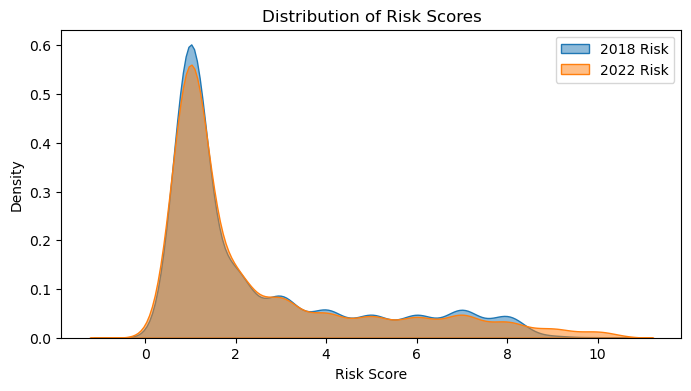

In [33]:
plt.figure(figsize=(8, 4))
sns.kdeplot(sample_data['score_2018'], label='2018 Risk', fill=True, alpha=0.5)
sns.kdeplot(sample_data['score_2022'], label='2022 Risk', fill=True, alpha=0.5)
plt.title("Distribution of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [34]:
print("Descriptive Statistics:\n")
print(sample_data[['score_2018', 'score_2022','risk_diff']].describe())

Descriptive Statistics:

        score_2018   score_2022    risk_diff
count  5991.000000  5991.000000  5991.000000
mean      2.439659     2.513270     0.073610
std       2.171831     2.335567     0.574433
min       0.000000     0.000000    -6.000000
25%       1.000000     1.000000     0.000000
50%       1.000000     1.000000     0.000000
75%       3.000000     3.000000     0.000000
max      10.000000    10.000000     6.000000


In [35]:
sample_data['risk_diff'].value_counts()

 0.0    5552
 2.0     121
-1.0     119
 1.0      85
 4.0      41
 3.0      41
-2.0      22
-3.0       3
-4.0       3
 6.0       2
 5.0       1
-6.0       1
Name: risk_diff, dtype: int64

### 4.3 Identifying Locations with Significant Risk Changes

I identified locations with significant risk changes by filtering areas where the risk difference (risk_diff) was less than or equal to -3 or greater than or equal to 5. These locations were sorted by risk_diff to highlight areas with the most dramatic changes in wildfire risk between 2018 and 2022. 

**Decreased Risk: Western United States** (e.g., latitudes around 34-38 and longitudes around -117 to -122).
The **western United States**, including **California**, **Oregon**, and **Washington**, has seen a **concentration of decreased wildfire risk**.

**Possible Reasons**:
  1. Improved Forest Management:
  Controlled burns and thinning practices have reduced the accumulation of dry vegetation, lowering fire intensity and spread.
  2. Policy and Infrastructure Improvements:
  Significant investments in firefighting infrastructure and stricter building codes for fire-prone areas.
  3. Fire Prevention Awareness:
  Public awareness campaigns and stricter regulations on fire-sparking activities, such as campfires and power line maintenance.

**Increased Risk: Central and Eastern United States**, as seen with latitude 36.710467.
Areas in the **central and eastern United States**, such as the **Great Plains** and **Southeast**, have experienced **increased wildfire risk**.

**Possible Reasons**:
  1. Changing Climate:
    Rising temperatures and extended drought periods create conditions favorable for wildfires in traditionally less fire-prone areas.
  2. Invasive Vegetation:
    The spread of invasive grasses, such as **cheatgrass**, has increased fuel loads, making wildfires more likely and harder to control.

In [36]:
# Select location with significant risk change
sign_diff = sample_data[(sample_data['risk_diff'] <= -3) | (sample_data['risk_diff'] >= 5)]
sign_diff = sign_diff.sort_values(by='risk_diff', ascending=True)
# Print the filtered locations
print("Locations risk with significant changes:")
sign_diff[['longitude', 'latitude', "score_2018","score_2022", 'risk_diff']]

Locations risk with significant changes:


,longitude,latitude,score_2018,score_2022,risk_diff
5302,-122.456167,37.695160,8.0,2.0,-6.0
2085,-122.774887,38.562761,8.0,4.0,-4.0
3039,-116.300059,43.549494,8.0,4.0,-4.0
3553,-117.097753,46.382644,7.0,3.0,-4.0
1189,-96.192686,36.090827,7.0,4.0,-3.0
4947,-117.014812,33.956152,9.0,6.0,-3.0
5370,-118.526650,34.282560,8.0,5.0,-3.0
2469,-118.382580,34.435622,5.0,10.0,5.0
2575,-122.711740,38.282199,2.0,8.0,6.0
4883,-96.981764,36.710467,4.0,10.0,6.0


### 4.4 Visualizations highlight geographic areas with significant changes

In [37]:
# Initialize the map centered around the US (adjust the location and zoom as needed)
m_risk_2022 = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Create a list of data points for the heat map
heat_data = [
    [row['latitude'], row['longitude'], row['score_2022']] 
    for index, row in sample_data.iterrows()
]

# Add the heat map to the folium map
HeatMap(heat_data, min_opacity=0.5, radius=10, blur=10, max_zoom=13).add_to(m_risk_2022)

m_risk_2022.save("map2022.html")

# Combine the two maps horizontally using an HTML layout
# HTML layout with titles and maps
html = """
<div style="display: flex; flex-direction: row; justify-content: space-around; align-items: flex-start;">
    <div style="text-align: center; width: 50%;">
        <h3>Map 1: Model 2018</h3>
        <iframe src="map2018.html" width="100%" height="500"></iframe>
    </div>
    <div style="text-align: center; width: 50%;">
        <h3>Map 2: Model 2022</h3>
        <iframe src="map2022.html" width="100%" height="500"></iframe>
    </div>
</div>
"""

# Display the combined maps
HTML(html)

When we zoom in both map, the heatmaps provide a visual comparison of wildfire risk predictions between 2018 and 2022. In the 2018 map, high-risk areas are concentrated around regions like Seattle and Tacoma, with a clear intensity of predicted risks. The 2022 map shows similar patterns but with slight shifts in the intensity and distribution of risks, indicating changes in the model's predictions over time.

Additionally, the third map highlights areas with significant changes in risk scores (risk_diff). These changes are scattered across the U.S., with clusters of increased or decreased risks observed in several regions. This analysis highlights how the model's predictions have evolved spatially, suggesting potential impacts from updated data, model adjustments, or changing environmental conditions. The visualizations provide a basis for identifying regions where further analysis is needed to understand the cause of these shifts.

In [38]:
# Initialize the map centered around the US (adjust the location and zoom as needed)
m_risk_diff = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Create a list of data points for the heat map
heat_data = [
    [row['latitude'], row['longitude'], row['risk_diff']] 
    for index, row in sample_data.iterrows()
]

# Add the heat map to the folium map
HeatMap(heat_data, min_opacity=0.5, radius=10, blur=10, max_zoom=13).add_to(m_risk_diff)

#m_risk_diff.save("mapdiff.html")
m_risk_diff

### 4.5 Statistical analysis quantifies model drift and relationships

In [39]:
from scipy.stats import ttest_rel, pearsonr

# Paired T-Test
stat, p_value = ttest_rel(sample_data['score_2018'], sample_data['score_2022'])
print(f"Paired T-Test:\nStatistic: {stat}, P-value: {p_value}\n")

Paired T-Test:
Statistic: -9.918586335379167, P-value: 5.195706772850079e-23



**Why We Need a Paired T-Test**

A paired t-test is used to compare two related datasets—in this case, the wildfire risk scores from 2018 and 2022. It helps determine whether the differences in predictions between the two years are statistically significant. Since the scores are paired for the same locations, the test accounts for the dependency between the two datasets, making it more appropriate than an independent t-test.

**Interpretation of the Result:**

Test Statistic (stat): The test statistic is -9.92, which indicates the magnitude and direction of the difference. A large negative value suggests that the 2022 scores are generally higher than the 2018 scores.
P-value: **The p-value is 5.19e-23**, which is effectively zero. Since this value is much smaller than the typical significance level (e.g., 0.05), we reject the null hypothesis that there is no significant difference between the 2018 and 2022 scores.

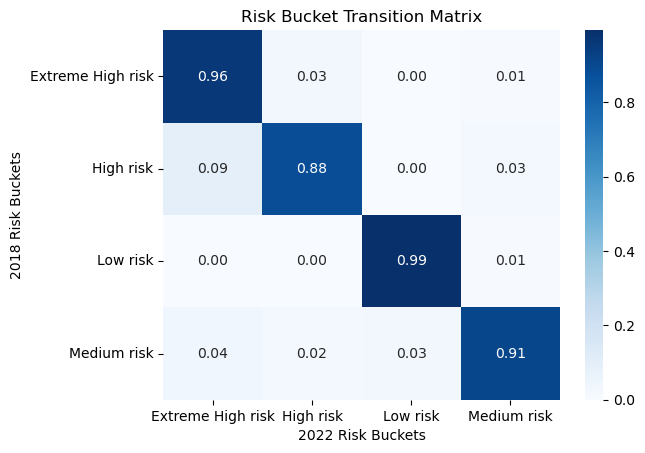

In [40]:
# Transition Matrix
transition_matrix = pd.crosstab(sample_data['risk_bucket_2018'], sample_data['risk_bucket_2022'], normalize='index')

sns.heatmap(transition_matrix, annot=True, cmap="Blues", fmt='.2f')
plt.title("Risk Bucket Transition Matrix")
plt.xlabel("2022 Risk Buckets")
plt.ylabel("2018 Risk Buckets")
plt.show()

This transition matrix highlights that while the majority of predictions remained consistent, there were small shifts in risk classification (eg. 4% of "Medium Risk" locations moved to "Extreme High Risk" or "High Risk."), particularly in higher-risk categories, reflecting potential model drift or evolving environmental factors affecting wildfire predictions.

**The Population Stability Index (PSI)** is a metric used to measure the extent of distributional change between two datasets—in this case, the 2018 and 2022 risk scores. It helps to assess how much the prediction model’s behavior has shifted over time.

In [41]:
def calculate_psi_10_buckets(score_2018, score_2022, buckets=10):
    """
    Calculate PSI using 10 equally spaced buckets.

    Parameters:
    - score_2018: Baseline distribution (Series or array-like, e.g., 2018 scores)
    - score_2022: New distribution (Series or array-like, e.g., 2022 scores)
    - buckets: Number of buckets (default=10)

    Returns:
    - PSI value
    """
    # Define bucket edges based on the combined range of scores
    min_score = min(score_2018.min(), score_2022.min())
    max_score = max(score_2018.max(), score_2022.max())
    bins = np.linspace(min_score, max_score, buckets + 1)  # Create 10 equally spaced bins

    # Assign scores to buckets
    score_2018_buckets = pd.cut(score_2018, bins=bins, include_lowest=True, labels=False)
    score_2022_buckets = pd.cut(score_2022, bins=bins, include_lowest=True, labels=False)

    # Calculate proportions for each bucket
    baseline_dist = score_2018_buckets.value_counts(normalize=True).sort_index()
    new_data_dist = score_2022_buckets.value_counts(normalize=True).sort_index()

    # Replace zeros to avoid division errors
    baseline_dist = np.where(baseline_dist == 0, 0.0001, baseline_dist)
    new_data_dist = np.where(new_data_dist == 0, 0.0001, new_data_dist)

    # Calculate PSI
    psi = np.sum((new_data_dist - baseline_dist) * np.log(new_data_dist / baseline_dist))
    return psi

# Example usage
# Assuming sample_data is a DataFrame with 'score_2018' and 'score_2022'
psi_value = calculate_psi_10_buckets(
    sample_data['score_2018'], 
    sample_data['score_2022']
)

print(f"PSI Value: {psi_value}")

PSI Value: 0.05590767802634887


With a PSI value of 0.0559 is considered low, indicating minimal changes between the 2018 and 2022 distributions. We can claim that the distribution of risk scores between 2018 and 2022 is very stable. This suggests that while there may be minor differences, the overall performance and behavior of the model have not changed significantly over time. However, it is still important to investigate any localized differences or significant shifts in specific regions or risk buckets to ensure accurate predictions.

**Why We Need K-Means Clustering**

K-Means clustering is employed to group locations with significant wildfire risk differences into clusters based on their geographic coordinates. This technique helps to identify regional patterns of risk change, making it easier to analyze and visualize areas with similar characteristics or risk dynamics. By clustering the data, we can pinpoint specific zones with shared trends in risk scores, enabling focused analysis or tailored interventions for wildfire risk management.

Optimal number of clusters (k): 6
                    mean  count
kmeans_cluster                 
0               0.825000     40
1               1.325088    283
2               0.444444      9
3               0.479167     48
4               0.317073     41
5              -0.388889     18


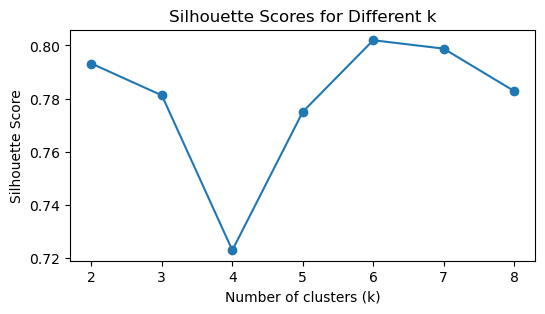

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Filter the data
drift_data = sample_data[sample_data['risk_diff'] != 0]

# Prepare geographic coordinates for clustering
coords = drift_data[['latitude', 'longitude']].values

# Step 1: Determine the optimal number of clusters (k) using Silhouette Score
best_k = None
best_score = -1
k_range = range(2, 9)  
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords)
    score = silhouette_score(coords, labels)  # Silhouette score
    silhouette_scores.append(score)
    if score > best_score:
        best_k = k
        best_score = score

print(f"Optimal number of clusters (k): {best_k}")

# Step 2: Apply K-Means with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
drift_data['kmeans_cluster'] = kmeans.fit_predict(coords)

# Step 3: Calculate mean and count for each K-Means cluster
cluster_summary = drift_data.groupby('kmeans_cluster')['risk_diff'].agg(['mean', 'count'])

# Print the summary
print(cluster_summary)

# Step 4: Calculate Risk_diff_mean for each cluster
cluster_summary = drift_data.groupby('kmeans_cluster').agg(
    risk_diff_mean=('risk_diff', 'mean')
).reset_index()

# Merge the Risk_diff_mean back into the original DataFrame
drift_data = drift_data.merge(cluster_summary, on='kmeans_cluster', how='left')

# Optional: Plot the silhouette scores
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

Using the Silhouette Score, we determined the optimal number of clusters to be 6, indicating well-defined groupings of locations with significant risk differences. The clusters exhibited varying mean risk differences, ranging from -0.39 to 1.32, highlighting regions with both risk increases and decreases. The largest cluster contained 283 locations, while the smallest had only 9 locations, illustrating that some areas experienced more concentrated or extreme changes in wildfire risk over time. 

In [43]:
kmeans_map = folium.Map(location=[37.0902, -103.7129], zoom_start=4)

# Add points for each data location, colored by cluster
for _, row in drift_data.iterrows():
    cluster = row['kmeans_cluster']
    risk_2018 = row['score_2018']
    risk_diff = row['risk_diff']
    risk_diff_mean = row['risk_diff_mean']
    cluster_colors = ['blue', 'green', 'purple', 'orange', 'pink','red']
    color = cluster_colors[cluster % len(cluster_colors)]  # Generate a random color for each cluster
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Risk_2018: {risk_2018}, Lat: {row['latitude']}, Lon: {row['longitude']},Risk diff: {row['risk_diff']}"
    ).add_to(kmeans_map)

# Add cluster centroids to the map
for idx, centroid in enumerate(kmeans.cluster_centers_):
    risk_diff_mean = cluster_summary.loc[cluster_summary['kmeans_cluster'] == idx, 'risk_diff_mean'].values[0]
    folium.Marker(
        location=[centroid[0], centroid[1]],
        icon=folium.Icon(color='red', icon='info-sign'),
        tooltip=f"Centroid {idx}, Risk_diff_mean: {risk_diff_mean:.2f}"
    ).add_to(kmeans_map)

# Save the map to an HTML file
kmeans_map.save("kmeans_interactive_map.html")
kmeans_map

#### Geographic Patterns of Risk Change by Cluster
Overall, the West Coast, particularly California and the Pacific Northwest, demonstrates the most dynamic changes, with both significant increases and reductions in wildfire risk. The central and southern U.S. reveal emerging risks with moderate increases, while regions such as the Midwest and Rocky Mountains remain relatively stable. 


**Cluster 0 (Blue)**:
Representing regions in the central and southern United States, particularly spanning parts of Texas and Oklahoma, this cluster shows a moderate increase in wildfire risk. The geographic spread suggests that these regions may be influenced by seasonal weather patterns, increasing vegetation flammability, or changes in land use.

**Cluster 1 (Green)**:
Concentrated in California and the Pacific Northwest, this cluster exhibits the largest increase in wildfire risk. These regions are well-known for their susceptibility to intense wildfires, exacerbated by prolonged droughts, rising temperatures, and human activities. The geographic concentration highlights areas that require immediate mitigation efforts and resource allocation.

**Cluster 2 (Purple)**:
Found in isolated pockets across the western U.S., such as parts of Nevada and Arizona, this cluster exhibits a small positive risk increase. Localized risk factors, such as vegetation growth or increased human encroachment into previously undeveloped areas, may be contributing to this change.

**Cluster 3 (Orange)**:
Spanning regions in the Rocky Mountains and surrounding areas, including parts of Colorado and Utah, this cluster shows a small increase in risk. This could be attributed to gradual changes in forest density, mild climatic shifts, or evolving land management practices. These regions highlight areas for preventive measures to avoid further escalation.

**Cluster 4 (Pink)**:
Found in parts of the Midwest and Southeast, this cluster exhibits a very slight increase in risk. These regions are relatively stable compared to others but may reflect early signs of emerging risks due to expanding agricultural land use or sporadic fire weather conditions.

**Cluster 5 (Red)**:
Representing locations in Northern California and parts of Oregon, this cluster demonstrates a moderate decrease in wildfire risk. This decline may be due to successful wildfire management strategies, such as prescribed burns, vegetation control, or reduced fire ignition sources. The geographic aspect of this cluster suggests effective practices that could be adopted in other high-risk areas.

### 4.6 Task 2 Conclusion

Over time, the model's wildfire risk predictions have shown noticeable changes, as evidenced by the comparison of 2018 and 2022 risk scores. The distribution of risk scores between these years indicates a slight overall increase in average risk, with a mean risk difference of 0.07. However, the risk changes are not uniform across all regions. Clustering analysis revealed that areas such as California and the Pacific Northwest experienced the most significant increases, while some locations, particularly in Northern California, showed moderate risk reductions. A paired T-test confirmed a statistically significant shift in risk scores, and the Risk Bucket Transition Matrix highlighted that most extreme high-risk and low-risk areas remained stable, while transitions were more frequent in medium and high-risk categories. These findings suggest that the model's predictions are adapting to changes in environmental and human-driven factors, reflecting evolving wildfire conditions and potential model drift over time.

**Appreciation**

Thank you for taking the time to review this analysis of wildfire risk predictions. Your interest and attention to this project are greatly appreciated. I hope the insights, findings, and methodologies presented here provide valuable perspectives on wildfire prediction and management. Your feedback and thoughts are always welcome, as they can help refine and improve future analyses. Thank you again for your time and engagement! 

Feel free to connect with me for further discussions or questions:

- **Email**: [hongyi.zhan@mail.mcgill.ca](mailto:hongyi.zhan@mail.mcgill.ca)
- **LinkedIn**: [ca.linkedin.com/in/hongyi-zhan](https://www.linkedin.com/in/hongyi-zhan/)